# Business Case 4

##  ManyGiftsUK: Online Retailer Recommender System

**Group members:**
- Lorenzo Pigozzi	--- m20200745
- Nguyen Huy Phuc	--- m20200566
- Ema Mandura	  --- m20200647
- Xavier Goncalves  --- m20201090

**Expected outcomes**
- Explore the data and build models to answer the problems:
 - Recommender system: appears in the website homepage and offers a wide range of relevant products to each user;
 - Cold start: offer relevant products to new customers;
- Implement adequate evaluation strategies and select an appropriate quality measure
- In the deployment phase, elaborate on the challenges and recommendations in implementing the recommender system


<a class="anchor" id="0.1"></a>
# **Table of Contents**

1.	[Importing data and libraries](#1)   
2.	[Exploratory data analysis (EDA)](#2)       
3.	[Data Cleaning](#3) 
4.	[Data Preprocessing](#4) 
5.	[Modeling](#5) 

# 1. Importing data and libraries <a class="anchor" id="1"></a>

In [169]:
# Import packages
import pandas as pd
import numpy as np
import datetime as dt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from os import path
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split

from scipy.sparse import csr_matrix

from lightfm import LightFM

In [117]:
# importing the data
df = pd.read_csv('retail.csv')

# 2. Exploratory Data Analysis <a class="anchor" id="2"></a>

In [118]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [119]:
df.shape

(541909, 8)

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [121]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [122]:
# Describe dataset
df.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900,4070,4223,NaN,23260,NaN,NaN,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,10/31/2011 14:41,NaN,NaN,United Kingdom
freq,1114,2313,2369,NaN,1114,NaN,NaN,495478
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000,NaN
50%,NaN,NaN,NaN,3.000000,NaN,2.080000,15152.000000,NaN
75%,NaN,NaN,NaN,10.000000,NaN,4.130000,16791.000000,NaN


In [123]:
df['Description']

0          WHITE HANGING HEART T-LIGHT HOLDER
1                         WHITE METAL LANTERN
2              CREAM CUPID HEARTS COAT HANGER
3         KNITTED UNION FLAG HOT WATER BOTTLE
4              RED WOOLLY HOTTIE WHITE HEART.
                         ...                 
541904            PACK OF 20 SPACEBOY NAPKINS
541905           CHILDREN'S APRON DOLLY GIRL 
541906          CHILDRENS CUTLERY DOLLY GIRL 
541907        CHILDRENS CUTLERY CIRCUS PARADE
541908          BAKING SET 9 PIECE RETROSPOT 
Name: Description, Length: 541909, dtype: object

In [124]:
# checking the top countries
top_countries = pd.DataFrame(df['Country'].value_counts().head(10)).reset_index()
top_countries.columns = ['Country', 'value']

fig = px.bar(top_countries, y = 'Country', x = 'value', orientation='h', 
             color="Country", color_discrete_sequence=px.colors.qualitative.Antique,
            title='Top countries')
fig.show()

In [125]:
# checking the top customers
top_custumers = pd.DataFrame(df['CustomerID'].astype(object).value_counts().head(10)).reset_index()
top_custumers.columns = ['Customer', 'value']

fig = px.bar(top_custumers, y = 'Customer', x = 'value', orientation='h', 
             color="Customer", color_discrete_sequence=px.colors.qualitative.Antique,
            title='Top Customers')
fig.show()

In [126]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [127]:
df.groupby('CustomerID').sum('Quantity').sort_values('Quantity', ascending = False).head(10)

,Quantity,UnitPrice
CustomerID,,
14646.0,196719,5400.21
12415.0,77242,2499.82
14911.0,77180,31060.66
17450.0,69029,3320.09
18102.0,64122,5159.73
17511.0,63012,2607.08
13694.0,61803,1163.81
14298.0,58021,2455.50
14156.0,57025,6544.29


In [128]:
df.groupby('Country').sum('Quantity').sort_values('Quantity', ascending = False).head(10)

,Quantity,UnitPrice,CustomerID
Country,,,
United Kingdom,4263829,2.245715e+06,5.626433e+09
Netherlands,200128,6.492550e+03,3.419054e+07
EIRE,142637,4.844719e+04,1.103917e+08
Germany,117448,3.766600e+04,1.200751e+08
France,110480,4.303199e+04,1.076489e+08
Australia,83653,4.054750e+03,1.569300e+07
Sweden,35637,1.806830e+03,6.790083e+06
Switzerland,30325,6.813690e+03,2.377592e+07
Spain,26824,1.263345e+04,3.268929e+07


Text(0.5, 1.0, 'Histogram')

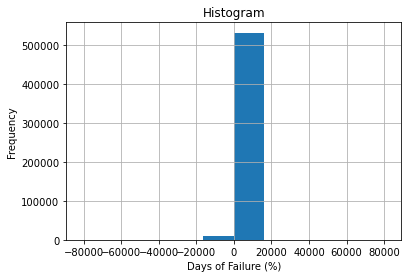

In [129]:
# distribution of the quantity
df['Quantity'].hist()
plt.ylabel('Frequency')
plt.xlabel('Days of Failure (%)')
plt.title('Histogram')

<AxesSubplot:>

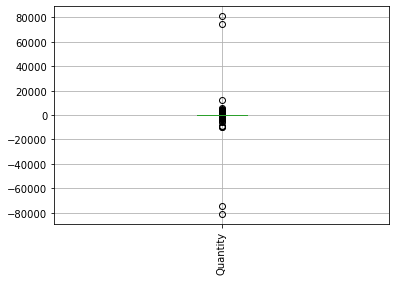

In [130]:
df.boxplot(column='Quantity', rot=90)

Text(0.5, 1.0, 'Histogram')

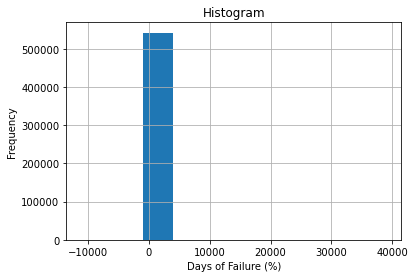

In [131]:
# distribution of the quantity
df['UnitPrice'].hist()
plt.ylabel('Frequency')
plt.xlabel('Days of Failure (%)')
plt.title('Histogram')

In [138]:
# changing the type of the InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [151]:
# distribution of days over the year
date_frequency = df['InvoiceDate'].dt.date.value_counts().reset_index()
date_frequency.columns = ['date', 'total_frequency']
date_frequency = date_frequency.sort_values(by='date')
##plotting##
data_for_plot = dict(type='scatter',
                x=date_frequency['date'],
                y=date_frequency['total_frequency'])
# setting the layout
plot_1_layout = dict(title=dict(text='Frequency purchases per day'),
                      xaxis=dict(title='Day'),
                      yaxis=dict(title='Total Frequency')
                      )
# displaying the graph
plot_1 = go.Figure(data=data_for_plot, layout=plot_1_layout)
# plot_1.show(renderer='png')
plot_1.show()

In [152]:
# distribution of hours of the day
date_frequency = df['InvoiceDate'].dt.time.value_counts().reset_index()
date_frequency.columns = ['date', 'total_frequency']
date_frequency = date_frequency.sort_values(by='date')
##plotting##
data_for_plot = dict(type='scatter',
                x=date_frequency['date'],
                y=date_frequency['total_frequency'])
# setting the layout
plot_1_layout = dict(title=dict(text='Frequency purchases per day'),
                      xaxis=dict(title='Day'),
                      yaxis=dict(title='Total Frequency')
                      )
# displaying the graph
plot_1 = go.Figure(data=data_for_plot, layout=plot_1_layout)
# plot_1.show(renderer='png')
plot_1.show()

In [153]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [161]:
df.sort_values('Quantity', ascending = False)[['Description', 'Quantity']].head(10)

,Description,Quantity
540421,"PAPER CRAFT , LITTLE BIRDIE",80995
61619,MEDIUM CERAMIC TOP STORAGE JAR,74215
502122,ASSTD DESIGN 3D PAPER STICKERS,12540
74614,NaN,5568
421632,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800
206121,SMALL POPCORN HOLDER,4300
220843,?,4000
97432,EMPIRE DESIGN ROSETTE,3906
270885,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,3186
160546,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114


In [162]:
df.sort_values('Quantity', ascending = True)[['Description', 'Quantity']].head(10)

,Description,Quantity
540422,"PAPER CRAFT , LITTLE BIRDIE",-80995
61624,MEDIUM CERAMIC TOP STORAGE JAR,-74215
225529,printing smudges/thrown away,-9600
225530,printing smudges/thrown away,-9600
4287,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360
225528,Printing smudges/thrown away,-9058
115818,throw away,-5368
431381,"Unsaleable, destroyed.",-4830
341601,NaN,-3667
323458,NaN,-3167


In [166]:
df.sort_values('UnitPrice', ascending = False)[['Description', 'UnitPrice']].head(10)

,Description,UnitPrice
222681,Manual,38970.00
524602,AMAZON FEE,17836.46
43702,AMAZON FEE,16888.02
43703,AMAZON FEE,16453.71
15017,AMAZON FEE,13541.33
16356,AMAZON FEE,13541.33
15016,AMAZON FEE,13541.33
16232,AMAZON FEE,13474.79
524601,AMAZON FEE,11586.50
299982,Adjust bad debt,11062.06


In [165]:
df.sort_values('UnitPrice', ascending = True)[['Description', 'UnitPrice']].head(10)

,Description,UnitPrice
299984,Adjust bad debt,-11062.06
299983,Adjust bad debt,-11062.06
40984,TRAVEL SEWING KIT,0.00
52217,NaN,0.00
52262,NaN,0.00
344867,Damaged,0.00
204945,NaN,0.00
104419,PORCELAIN BUTTERFLY OIL BURNER,0.00
104418,BLUE POLKADOT PASSPORT COVER,0.00
115488,Thrown away.,0.00


# 3. Data Cleaning <a class="anchor" id="3"></a>

**Notes**
\
The EDA has shown that in order to procede to the modeling phase, a data cleaning step is necessary.



List of issues to fix:
- UnitPrice negative values
- Quantity negative values
- Outliers in Quantity and UnitPrice

In [173]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [183]:
df.shape

(541909, 8)

In [186]:
print('Number of transactions with negative price: ', df.shape[0] - df[df['UnitPrice'] > 0].shape[0], 
     ', representing the ', ((df.shape[0] - df[df['UnitPrice'] > 0].shape[0])/df.shape[0])*100,
      '% of the data')
print('Number of transactions with negative quantity: ', df.shape[0] - df[df['Quantity'] > 0].shape[0], 
     ', representing the ', ((df.shape[0] - df[df['Quantity'] > 0].shape[0])/df.shape[0])*100,
      '% of the data')

Number of transactions with negative price:  2517 , representing the  0.46446912673530055 % of the data
Number of transactions with negative quantity:  10624 , representing the  1.9604767590130447 % of the data


In [187]:
#  drop those rows
df = df[df['UnitPrice'] > 0]
df = df[df['Quantity'] > 0]

In [188]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [189]:
## Outliers

# 4. Data Preprocessing <a class="anchor" id="4"></a>

Idea\
Creating 2 csr matrices, one for the interactions among InvoiceNo and StockCode and one for the interactions among StockCode and CustomerID

In [218]:
# interactions among invoices and products, values the quantities
interactions_selected = df[['InvoiceNo', 'StockCode', 'Quantity']]

In [219]:
# creating the csr matrix
invoice_product_interactions = pd.pivot_table(interactions_selected, 
                                       index='InvoiceNo', columns='StockCode')
# fill missing values with 0
invoice_product_interactions = invoice_product_interactions.fillna(0)
InvoiceNo = list(invoice_product_interactions.index)
invoice_dict = {}
counter = 0 
for i in InvoiceNo:
    invoice_dict[i] = counter
    counter += 1    
# convert to csr matrix
invoice_product_interactions_csr = csr_matrix(invoice_product_interactions.values)
invoice_product_interactions_csr

<19960x3922 sparse matrix of type '<class 'numpy.float64'>'
	with 519602 stored elements in Compressed Sparse Row format>

In [223]:
# interactions among Customers and products, values the quantities
interactions_selected_2 = df[['CustomerID', 'StockCode', 'Quantity']]

In [226]:
# creating the csr matrix
customer_product_interactions = pd.pivot_table(interactions_selected_2, 
                                       index='CustomerID', columns='StockCode')
# fill missing values with 0
customer_product_interactions = customer_product_interactions.fillna(0)
CustomerID = list(customer_product_interactions.index)
customer_dict = {}
counter = 0 
for i in CustomerID:
    customer_dict[i] = counter
    counter += 1    
# convert to csr matrix
customer_product_interactions_csr = csr_matrix(customer_product_interactions.values)
customer_product_interactions_csr

<4338x3665 sparse matrix of type '<class 'numpy.float64'>'
	with 266792 stored elements in Compressed Sparse Row format>

# 5. Modeling <a class="anchor" id="3"></a>

**Ranking Problem:**\
"Other times, we wish to recommend the top-k items for a particular user or determine the top-k users to target for a specific topic. This problem is also referred to as the top-k recommendation problem, and it is the ranking formulation of the recommendation problem."\
\
Attribution Information, about each users and items ---> Content Base Filtering method
\
https://towardsdatascience.com/recommendation-system-in-python-lightfm-61c85010ce17

\
\
LighFM documentation: https://making.lyst.com/lightfm/docs/lightfm.html

In [ ]:
# ## train-validation-test split
# train, test = train_test_split(df, test_size=0.2)
# test, dev = train_test_split(test, test_size=0.5)

In [232]:
model = LightFM(loss='warp',
                random_state=2016,
                learning_rate=0.90,
                no_components=150,
                user_alpha=0.000005)

In [233]:
model = model.fit(customer_product_interactions_csr,
                  epochs=10,
                  num_threads=16, 
                  verbose=False)

## Top N-recommendations

In [240]:
StockCode = list(customer_product_interactions.columns.droplevel())
item_dict = {}
counter = 0 
for i in StockCode:
    item_dict[i] = counter
    counter += 1  

In [252]:
def sample_recommendation_user(model, interactions, customer_id, user_dict, 
                               item_dict,threshold = 0,nrec_items = 5, show = True):
    
    n_users, n_items = interactions.shape
    customer_x = customer_dict[customer_id]
    quantity = pd.Series(model.predict(customer_x,np.arange(n_items)))
    quantity.index = interactions.columns.droplevel()
    quantity = list(pd.Series(quantity.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[CustomerID,:] \
                                 [interactions.loc[CustomerID,:] > threshold].index).sort_values(ascending=False))
    
    quantity = [x for x in quantity if x not in known_items]  
    return_score_list = quantity[0:nrec_items] 
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))    
    quantity = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    
    if show == True:
        print ("Customer: " + str(CustomerID))
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + i)
            counter+=1

            
    print("\n Recommended Items:")
    counter = 1
    for i in quantity:
        print(str(counter) + '- ' + i)
        counter+=1

In [264]:
# sample_recommendation_user(model, customer_product_interactions, 
#                            17850.0, customer_dict, item_dict)